# Notebook for illustrating ill-conditioning of deconvolution

In [2]:
# download test image
!wget https://jpegai.github.io/public/test_set/00004_TE_1808x1352.png.zip
!unzip 00004_TE_1808x1352.png.zip

--2023-07-24 13:48:29--  https://jpegai.github.io/public/test_set/00004_TE_1808x1352.png.zip
Resolving jpegai.github.io (jpegai.github.io)... 2606:50c0:8001::153, 2606:50c0:8003::153, 2606:50c0:8000::153, ...
Connecting to jpegai.github.io (jpegai.github.io)|2606:50c0:8001::153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4806201 (4.6M) [application/zip]
Saving to: ‘00004_TE_1808x1352.png.zip.2’

00004_TE_1808x1352. 100%[===================>]   4.58M  23.3MB/s    in 0.2s    

2023-07-24 13:48:29 (23.3 MB/s) - ‘00004_TE_1808x1352.png.zip.2’ saved [4806201/4806201]



In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.metrics import structural_similarity as ssim


# Read image, resize, and make sure coordinates are between 0 and 1
img = Image.open('00004_TE_1808x1352.png')
width,height = img.size
img = img.resize((width//2, height//2))
img_arr = np.array(img)/255

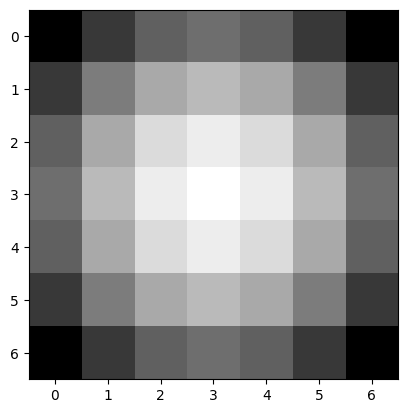

In [4]:
# Define Gaussian blur kernel
kernel_size = 7
sigma = 4
kernel = np.zeros((kernel_size, kernel_size))
for i in range(kernel_size):
    for j in range(kernel_size):
        kernel[i, j] = np.exp(-((i-kernel_size//2)**2 + (j-kernel_size//2)**2) / (2*sigma**2))
kernel /= kernel.sum()

plt.imshow(kernel, cmap='gray')
plt.show()

# Blur image with the kernel
#def blur_image(img_arr, kernel):
#    img_blur = np.zeros_like(img_arr)
#    for i in range(3): # Iterate over color channels
#        img_blur[:,:,i] = convolve2d(img_arr[:,:,i], kernel, mode='same', boundary='circular')
#    return img_blur

def blur_image(image, kernel):
    # Apply Fourier transform to each color channel of the image and kernel
    image_fft = np.dstack([np.fft.fft2(image[:,:,i]) for i in range(image.shape[2])])
    kernel_fft = np.dstack([np.fft.fft2(kernel, s=image[:,:,i].shape) for i in range(image.shape[2])])

    # Convolve the Fourier transformed image and kernel for each channel
    image_blur_fft = image_fft * kernel_fft

    # Apply inverse Fourier transform to the convolved image for each channel
    image_blur = np.dstack([np.fft.ifft2(image_blur_fft[:,:,i]).real for i in range(image.shape[2])])

    return image_blur




# Define Fourier deconvolution function for one channel
def fourier_deconvolution1channel(img_blur, kernel, eps=1e-3):
    # Compute Fourier transforms of image and kernel
    img_fft = np.fft.fft2(img_blur, axes=(0,1))
    kernel_fft = np.fft.fft2(kernel, s=img_blur.shape[:2], axes=(0,1))

    # Deconvolve in Fourier domain
    kernel_fft_conj = np.conj(kernel_fft)
    img_fft_deconv = (kernel_fft_conj / (np.abs(kernel_fft)**2 + eps)) * img_fft
    img_deconv = np.real(np.fft.ifft2(img_fft_deconv, axes=(0,1)))

    return img_deconv

# Fourier deconvolution for all channels
def fourier_deconvolution(img_blur, kernel, eps=1e-3):
    img_deconv = np.zeros_like(img_blur)
    for i in range(3):
        img_deconv[:,:,i] = fourier_deconvolution1channel(img_blur[:,:,i], kernel, eps)
    return img_deconv

def save_numpy_img(img, path):
    #img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img = img / np.max(img)

    img = (img * 255).astype('uint8')
    img = Image.fromarray(img,mode='RGB')
    img.save(path)

# Function to compute PSNR between two images

# plot img_arr and img_blur

# Deconvolve image



def PSNR(img,hatimg):
    mse = np.sum((img-hatimg)**2) / np.prod(img.shape)
    if mse == 0:
        return 100
    PIXEL_MAX = np.max(img)
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

# normalize kernel to be in 0,255 range
kernel_normalized = (kernel - np.min(kernel)) / np.max(kernel) * 255
Image.fromarray(kernel_normalized.astype('uint8'),mode='L').save('./data/kernel.png')

# compute PSNR between two images
def PSNR(img,hatimg):
    mse = np.sum((img-hatimg)**2) / np.prod(img.shape)
    if mse == 0:
        return 100
    PIXEL_MAX = np.max(img)
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

# compute SSIM between two images
def SSIM(img,hatimg):
    return ssim(img,hatimg,multichannel=True)





### Pipeline 1: Blur, unblur

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


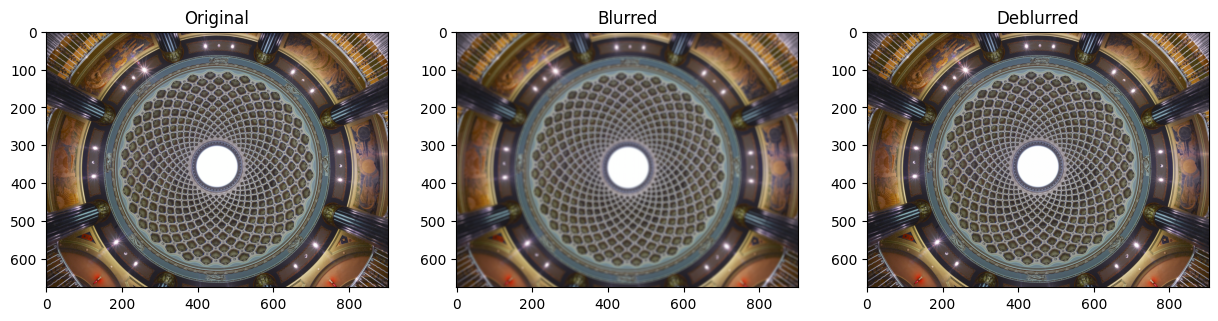

PSNR blurred:  17.7671351779794
PSNR deblurred:  58.45567702945955
SSIM blurred:  0.331028121951319
SSIM deblurred:  0.999680883012782
max diff: 0.006597981102422379
max diff: 0.9216857982087575


In [5]:
# blur image
img_blur = blur_image(img_arr, kernel)

# Deblur image with Fourier deconvolution
img_deblur = fourier_deconvolution(img_blur, kernel, eps=1e-10)

# Display original, blurred, and deblurred images side by side
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(img_arr)
ax[0].set_title('Original')
ax[1].imshow(img_blur)
ax[1].set_title('Blurred')
ax[2].imshow(img_deblur)
ax[2].set_title('Deblurred')
plt.show()

# clip img_deblur to be in 0,1 range
img_deblur = np.clip(img_deblur, 0, 1)

print("PSNR blurred: ", PSNR(img_arr,img_blur) )
print("PSNR deblurred: ", PSNR(img_arr,img_deblur ) )

print("SSIM blurred: ", ssim(img_arr, img_blur, channel_axis=2,data_range=1.0) )
print("SSIM deblurred: ", ssim(img_arr, img_deblur, channel_axis=2,data_range=1.0) )

print("max diff:", np.max(img_arr - img_deblur))
print("max diff:", np.max(img_arr - img_blur))


# save images  
save_numpy_img(img_arr, './data/p1_orig.png')
save_numpy_img(img_blur, './data/p1_blur.png')
save_numpy_img(img_deblur, './data/p1_deblur.png')


### Pipeline 2: Blur, add noise, unblur

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


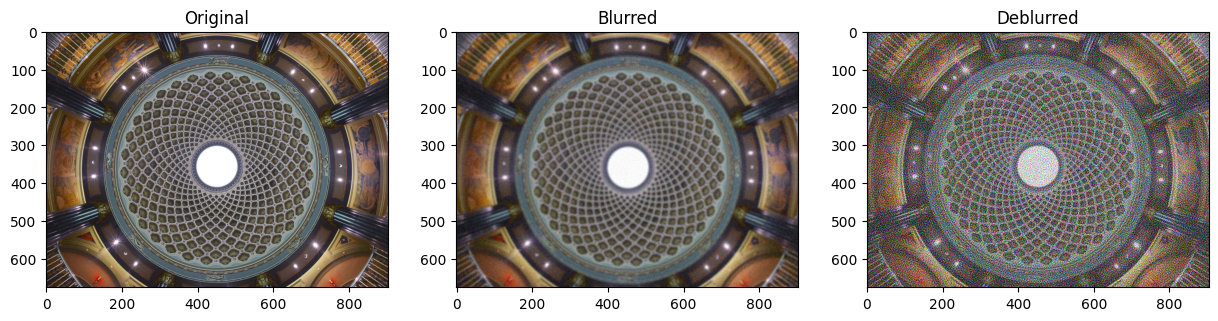

norm of img_arr, img_blur, and imge_deblur: 554.9183775164544 539.3002463675138 850.3218452757234
PSNR blurred:  17.16300052435219
PSNR deblurred:  6.343721010883959


In [6]:
# Blur image
img_blur = blur_image(img_arr, kernel)

# Add noise to img_deblur
img_blur = img_blur + 0.05 * np.random.randn(*img_blur.shape)

# Deblur image with Fourier deconvolution
img_deblur = fourier_deconvolution(img_blur, kernel, eps=1e-3)

# Display original, blurred, and deblurred images side by side
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(img_arr)
ax[0].set_title('Original')
ax[1].imshow(img_blur)
ax[1].set_title('Blurred')
ax[2].imshow(img_deblur)
ax[2].set_title('Deblurred')
plt.show()

print("norm of img_arr, img_blur, and imge_deblur:", np.linalg.norm(img_arr), np.linalg.norm(img_blur), np.linalg.norm(img_deblur))

print("PSNR blurred: ", PSNR(img_arr,img_blur) )
print("PSNR deblurred: ", PSNR(img_arr,img_deblur ) )

# save images  
save_numpy_img(img_arr, './data/p2_orig.png')
save_numpy_img(img_blur, './data/p2_blur.png')
save_numpy_img(img_deblur, './data/p2_deblur.png')

### Pipeline 3: Add noise, blur, unblur,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


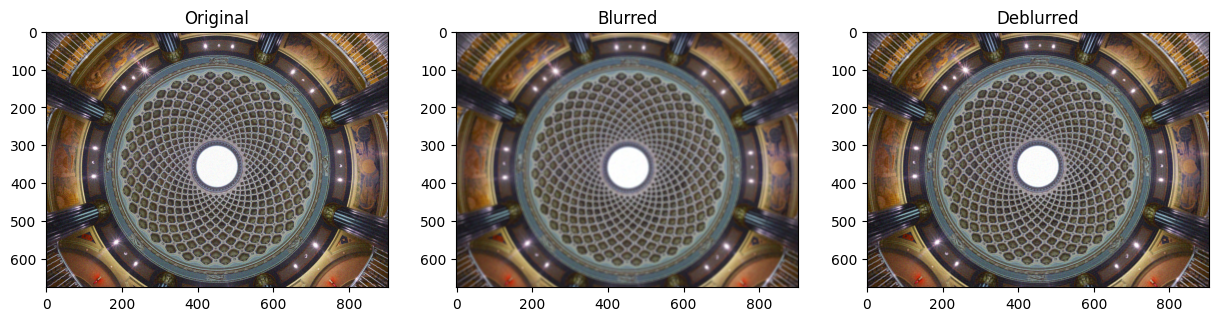

norm of img_noisy, img_blur, and imge_deblur: 559.0840224352737 535.1094079015112 549.9198114526796
PSNR blurred:  17.753735722224736
PSNR deblurred:  25.808045792727405


In [7]:
# add noise
img_noisy = img_arr + 0.05 * np.random.randn(*img_arr.shape)
# blur image
img_blur = blur_image(img_noisy, kernel)
# deblur image 
img_deblur = fourier_deconvolution(img_blur, kernel, eps=1e-3)

# Display original, blurred, and deblurred images side by side
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(img_noisy)
ax[0].set_title('Original')
ax[1].imshow(img_blur)
ax[1].set_title('Blurred')
ax[2].imshow(img_deblur)
ax[2].set_title('Deblurred')
plt.show()

print("norm of img_noisy, img_blur, and imge_deblur:", np.linalg.norm(img_noisy), np.linalg.norm(img_blur), np.linalg.norm(img_deblur))

print("PSNR blurred: ", PSNR(img_arr,img_blur) )
print("PSNR deblurred: ", PSNR(img_arr,img_deblur ) )

# save images  
save_numpy_img(img_arr, './data/p3_orig.png')
save_numpy_img(img_blur, './data/p3_blur.png')
save_numpy_img(img_deblur, './data/p3_deblur.png')


# 1D example to illustrate ill-conditioning

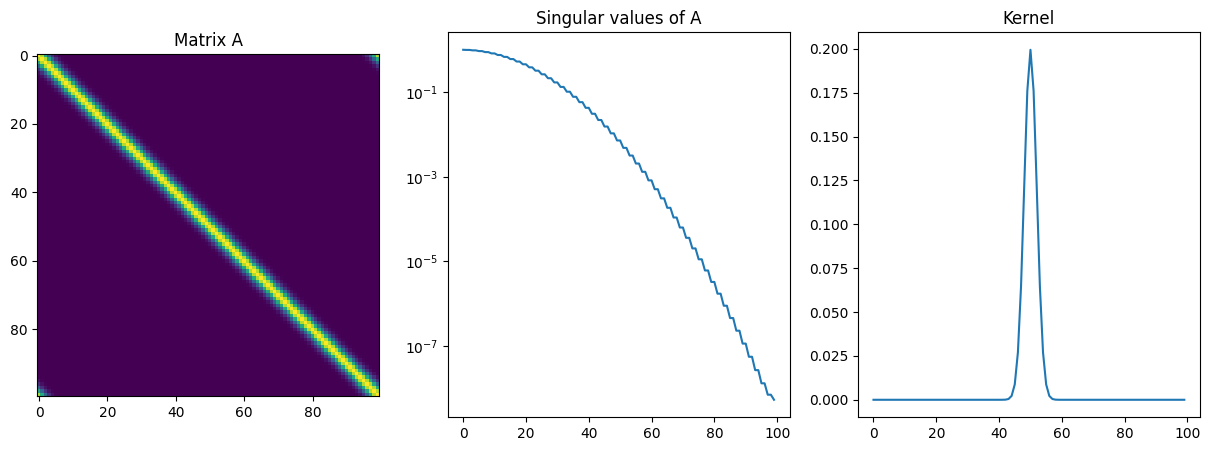

Relative error: 14760.44558751538


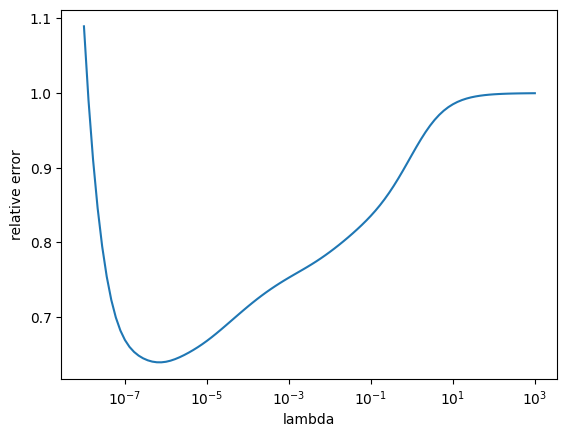

In [8]:
# matrix implementing circular convolution with a 1D-kernel
def conv_matrix_1d(kernel, n):
    m = len(kernel)
    A = np.zeros((n, n))
    for i in range(n):
        for j in range(m):
            A[i, (i + j) % n] = kernel[j]
    return A

# 1D-Gaussian kernel centered at 0
def gaussian_kernel_1d(sigma, n):
    kernel = np.zeros(n)
    for i in range(n):
        kernel[i] = np.exp(-0.5 * (i - n // 2) ** 2 / sigma ** 2)
    return kernel / np.sum(kernel)

n = 100
kernel = gaussian_kernel_1d(2, 100)
# shift kernel by n//2 to center it
kernel_shifted = np.roll(kernel, n // 2)
A = conv_matrix_1d(kernel_shifted, n)

# plot matrix A, its singular values, and kernel next to each other
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(A)
ax[0].set_title('Matrix A')
ax[1].semilogy(np.linalg.svd(A, compute_uv=False))
ax[1].set_title('Singular values of A')
ax[2].plot(kernel)
ax[2].set_title('Kernel')
plt.show()

# get a random signal x 
x = np.random.randn(n)
# compute convolution of x with kernel
y = A @ x
# add noise to y
y_noisy = y + 0.001 * np.random.randn(n)
# deconvolve y_noisy
x_deconv = np.linalg.inv(A) @ y_noisy

# compute relative error    
print("Relative error:", np.linalg.norm(x - x_deconv) / np.linalg.norm(x))

# closed form solution to minimize ||Ax - y||^2 + lambda ||x||^2
def closed_form_solution(A, y, lam):
    return np.linalg.inv(A.T @ A + lam * np.eye(A.shape[1])) @ A.T @ y

# compute relative error for different values of lambda and store in list
rel_errors = []

# lams on a log scale
# grid of log-spaced lambda values
lams = np.logspace(-8, 3, 100)

for lam in lams:
    x_deconv = closed_form_solution(A, y_noisy, lam)
    rel_errors.append(np.linalg.norm(x - x_deconv) / np.linalg.norm(x))

# plot relative error as a function of lambda
plt.semilogx(lams, rel_errors)
plt.xlabel('lambda')
plt.ylabel('relative error')
plt.show()


### export data for plotting in latex

# grid from 0 to n-1
grid = np.arange(n)
# singular values of A
s = np.linalg.svd(A, compute_uv=False)
# stack grid and singular values
data = np.stack((grid, s), axis=1)

# save data
np.savetxt('./data/1d_decconvolution_singular_values.csv', data, delimiter=',', header='grid,singular_values', comments='')

# stack grid and kernel
data = np.stack((grid, kernel), axis=1)
# save data
np.savetxt('./data/1d_decconvolution_kernel.csv', data, delimiter=',', header='grid,kernel', comments='')




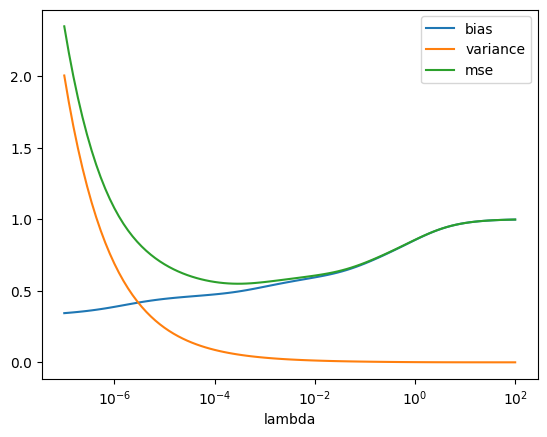

In [9]:
lams = np.logspace(-7, 2, 100)
noise_sigma = 0.01
xs = np.random.randn(n)
xs = xs / np.linalg.norm(xs)
# expected mean-squared error for different values of lambda
def bias(sigmas,lam,xs):
    return np.sum( np.array([ x**2 * (1 -  sigma ** 2 / (sigma ** 2 + lam))**2 for sigma,x in zip(sigmas,xs)]) )

def variance(sigmas,noise_sigma,lam):
    return noise_sigma**2 * np.sum( np.array([ (sigma / (sigma ** 2 + lam)) for sigma in sigmas]) )

# compute bias and variance for different values of lambda
sigmas = np.linalg.svd(A, compute_uv=False)
biases = [bias(sigmas,lam,xs) for lam in lams]
variances = [variance(sigmas,noise_sigma,lam) for lam in lams]
mse = np.array(biases) + np.array(variances)
# plot biases, variances, and mse as a function of lambda
plt.semilogx(lams, biases, label='bias')
plt.semilogx(lams, variances, label='variance')
plt.semilogx(lams, mse, label='mse')
plt.xlabel('lambda')
plt.legend()
plt.show()

# matrix containing lams, biases, variances, and mse as columns
data = np.array([lams, biases, variances, mse]).T
# write data matrix to file 
np.savetxt('./data/1d_decconvolution_bias_variance.dat', data, delimiter=',', header='lams, biases, variances, mse')
